Typical information

* How can the granular truck data most easily be understood?
* What can we understand about the trends of the trucks over time?
* Would you make any recommendations around the operations of the trucks?
* How has the operation performed financially compared to what was planned?
* How “efficient” have the costs been?


#Import

In [1]:
# check python version
!python --version

Python 3.7.11


In [35]:
import numpy as np
import pandas as pd
from copy import copy
from datetime import timedelta
from IPython import display

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')  # for animation
import seaborn as sns

In [3]:
%matplotlib inline

#1. Geospatial data

Process information to assist in making the appropriate decision when evaluating how to optimise the trucks (i.e. you are required to process the given information and provide us with a suggested areas of improvement
truck efficiency).

1. review and assess whether there are any trends we can identify from 
Geospatial Data over time (such as time spent during activities, sensitivities, ratios / rates, etc.).

Tips:
* Analyse
* Make observations
* Give reasons to why the observations are apparent
* Make recommendation

Notes:
* Mines often have a costly overhead component and rely on large volumes of ore throughput to operate profitably. Inefficiencies that decrease ore throughput and increase costs are a challenge that all open-pit mines face.
* Monthly fixed cost that is independent of the amount of ore extracted (even if the equipment is not used) as well as a variable cost component arising from fuels, lubricating agents, maintenance, and other metrics that are related to the use of equipment.

## Import Data

In [4]:
from google.colab import drive
 
# mount drive to access files, if this is local change root_path to file path to local
 
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Programming/datasets/mining/Truck_Geospatial_Output.csv'  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# read in data
df = pd.read_csv(root_path)  # if running locally change root_path to location of csv file

## Exploratory Data Analysis

Perform exploratory data analysis on the data set to identify any trends over time

In [6]:
# display head of the dataframe
df.head()

,Period,Truck,Speed,Latitude,Longitude,Location,Shift,Kms
0,2015-04-11 07:00,HT10,0.0,-25.777852,29.102282,Hard park,Day,0.0
1,2015-04-11 07:00,HT10,0.0,-25.777852,29.102282,Hard park,Day,0.0
2,2015-04-11 07:00,HT10,0.0,-25.777852,29.102282,Hard park,Day,0.0
3,2015-04-11 07:00,HT10,0.0,-25.777852,29.102282,Hard park,Day,0.0
4,2015-04-11 07:00,HT10,0.0,-25.777852,29.102282,Hard park,Day,0.0


In [7]:
# convert period column to datetime
df['Period'] = pd.to_datetime(df['Period'])

In [8]:
# just to be safe sort by period
df.sort_values(by=['Period'])
df.tail()

,Period,Truck,Speed,Latitude,Longitude,Location,Shift,Kms
33119,2015-04-12 05:59:00,HT13,0.0,-25.78017,29.101198,Operating,Night,0.0
33120,2015-04-12 05:59:00,HT13,0.0,-25.78017,29.101198,Operating,Night,0.0
33121,2015-04-12 05:59:00,HT13,0.0,-25.78017,29.101198,Operating,Night,0.0
33122,2015-04-12 05:59:00,HT13,0.0,-25.78017,29.101198,Operating,Night,0.0
33123,2015-04-12 06:00:00,HT13,0.0,-25.78017,29.101198,Operating,Night,0.0


### High level Analysis

Perform basic high level analysis of the data and look at the variation and spread of data as well as any correlations.

In [9]:
# display basic dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33124 entries, 0 to 33123
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Period     33124 non-null  datetime64[ns]
 1   Truck      33124 non-null  object        
 2   Speed      33124 non-null  float64       
 3   Latitude   33124 non-null  float64       
 4   Longitude  33124 non-null  float64       
 5   Location   33124 non-null  object        
 6   Shift      33124 non-null  object        
 7   Kms        33124 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 2.0+ MB


###Missing values

The data all has the same length and no missing values

<Figure size 720x432 with 0 Axes>

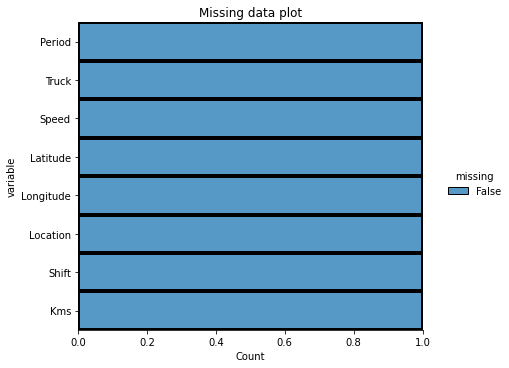

In [10]:
# Just to be 100% sure plot the missing and available data
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.title('Missing data plot')
plt.show()

###Data description

In [11]:
# describe the data
df.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,Period,Truck,Speed,Latitude,Longitude,Location,Shift,Kms
count,33124,33124,33124.000000,33124.000000,33124.000000,33124,33124,33124.000000
unique,1381,4,NaN,NaN,NaN,6,2,NaN
top,2015-04-11 10:43:00,HT13,NaN,NaN,NaN,Operating,Day,NaN
freq,24,8281,NaN,NaN,NaN,12111,17280,NaN
first,2015-04-11 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-04-12 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.998661,-25.790675,29.093030,NaN,NaN,0.024996
std,NaN,NaN,14.333630,0.013529,0.011456,NaN,NaN,0.039816
min,NaN,NaN,0.000000,-25.814085,29.075415,NaN,NaN,0.000000
25%,NaN,NaN,0.000000,-25.806120,29.078847,NaN,NaN,0.000000


####Observations:


*   Mean speed is very low compare to max speed as shown above
*   Operating is the biggest location. This is when the trucks are moving between locations
*   Lat and long reffer to position of truck at time period



###Data distributions

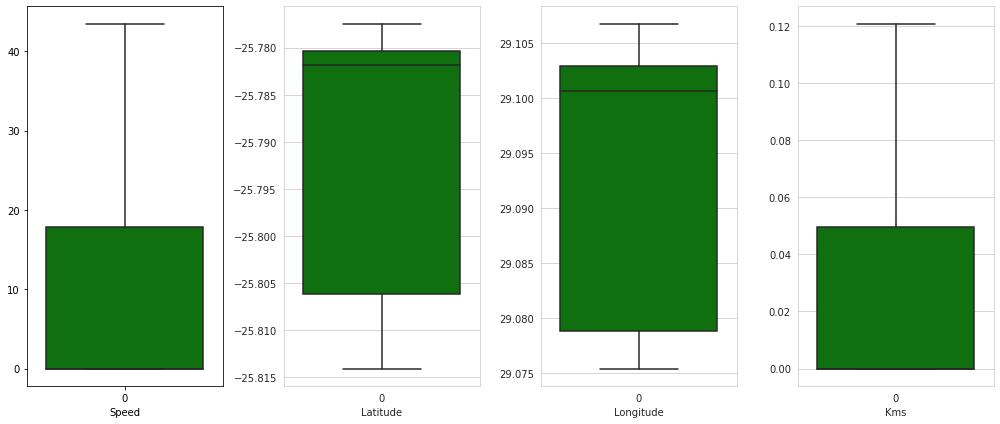

In [12]:
# plot a box plot to check for data distribution

def data_numeric_box_plot(dataframe, num_of_cols):
    col_names = dataframe.columns.values
    number_of_columns = num_of_cols
    number_of_rows = (len(col_names) - 1) / number_of_columns
    fig, ax = plt.subplots(figsize=(14, 6))
    for i in range(0, len(col_names)):
        plt.subplot(number_of_rows + 1, number_of_columns, i + 1)
        sns.set_style('whitegrid')
        sns.boxplot(
            data=dataframe[col_names[i]],
            color='green',
            orient='v').set(xlabel=col_names[i])
        plt.tight_layout()

data_numeric_box_plot(df.drop(['Period', 'Truck', 'Location', 'Shift'], axis=1), 4)

<Figure size 864x432 with 0 Axes>

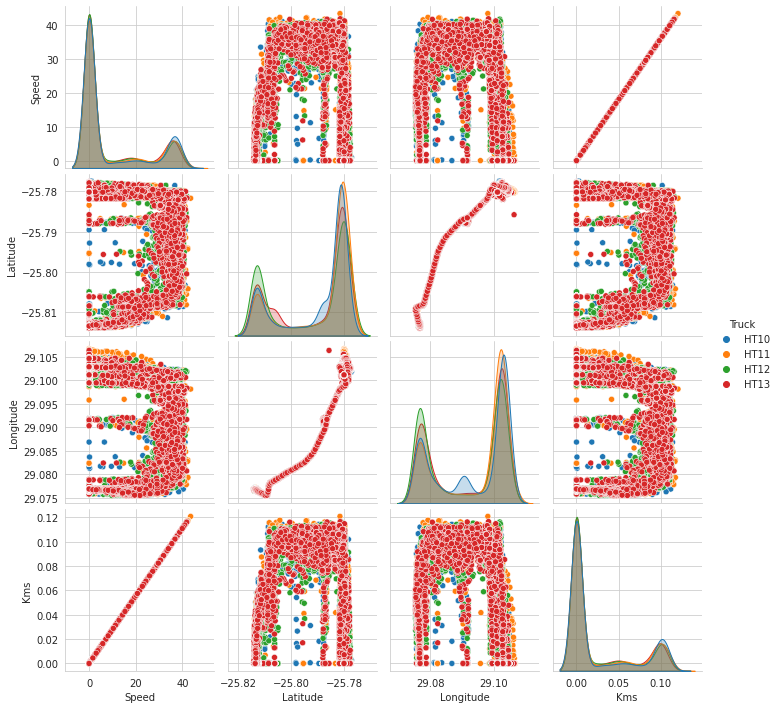

In [13]:
# check kde to check linearity of variabls
plt.figure(figsize=(12, 6))
sns.pairplot(df.drop('Period', axis=1), hue="Truck")
plt.show()

####Observations:

*   Median is high on Lattitude and longitude therefore 50% of data is concentrated in a relatively small location around -25.78 lat and 29.1 long. This could mean trucks staying in one location for the majority of the day
*   Speed and kms have similar variation in data which makes sense as they are both interrelated, reviewing the pair plot speed and km are linearly correlated



###Check for correlations

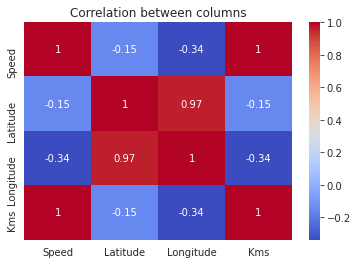

In [14]:
# plot heat map of correlations
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation between columns')
plt.show()

Observations:

* Lat and long are highly correlated however this is to be expected as they are interdependant
* Large correlation between speed and kms, however again this is to be expected
* No other real correlations to speak of

##Individual dataframes
Create individual dataframes for each truck

In [15]:
# determine all truck names
trucks = df['Truck'].unique()

In [16]:
# create individual dataframes for each truck
def create_truck_df(dataframe, truck_name):
  truck_df = dataframe[dataframe['Truck']==truck_name]
  return truck_df

df_HT10 = create_truck_df(df, 'HT10')
df_HT11 = create_truck_df(df, 'HT11')
df_HT12 = create_truck_df(df, 'HT12')
df_HT13 = create_truck_df(df, 'HT13')

# Plot dataframe head to check
df_HT13.head()

,Period,Truck,Speed,Latitude,Longitude,Location,Shift,Kms
24843,2015-04-11 07:00:00,HT13,0.0,-25.777863,29.10264,Hard park,Day,0.0
24844,2015-04-11 07:00:00,HT13,0.0,-25.777863,29.10264,Hard park,Day,0.0
24845,2015-04-11 07:00:00,HT13,0.0,-25.777863,29.10264,Hard park,Day,0.0
24846,2015-04-11 07:00:00,HT13,0.0,-25.777863,29.10264,Hard park,Day,0.0
24847,2015-04-11 07:00:00,HT13,0.0,-25.777863,29.10264,Hard park,Day,0.0


In [17]:
# check if there is the same number of datapoints for each truck

for truck_df in [df_HT11, df_HT12, df_HT13]:
  assert len(df_HT10) == len(truck_df)

## Shift change time

Investigate the shift change over time as this may become useful


In [106]:
def change_over(dataframe):

    day2night = dataframe[dataframe['Shift']=='Night']['Period'].min()
    night2day = dataframe[dataframe['Shift']=='Night']['Period'].max()
    print(f'Shift change over time (Day - Night): {day2night}')
    print(f'Shift change over time (Night to Day): {night2day}')

    return day2night, night2day

change_over_day2night, change_over_night2day = change_over(df)

Shift change over time (Day - Night): 2015-04-11 19:00:00
Shift change over time (Night to Day): 2015-04-12 06:00:00


In [107]:
# Determine change over time for all trucks to check if it is the same

HT10_change_over_day2night, HT10_change_over_night2day = change_over(df_HT10)


for truck_df in [df_HT11, df_HT12, df_HT13]:
  truck_change_over_day2night, truck_change_over_night2day = change_over(truck_df)
  assert HT10_change_over_day2night == truck_change_over_day2night
  assert HT10_change_over_night2day == truck_change_over_night2day

Shift change over time (Day - Night): 2015-04-11 19:00:00
Shift change over time (Night to Day): 2015-04-12 06:00:00
Shift change over time (Day - Night): 2015-04-11 19:00:00
Shift change over time (Night to Day): 2015-04-12 06:00:00
Shift change over time (Day - Night): 2015-04-11 19:00:00
Shift change over time (Night to Day): 2015-04-12 06:00:00
Shift change over time (Day - Night): 2015-04-11 19:00:00
Shift change over time (Night to Day): 2015-04-12 06:00:00


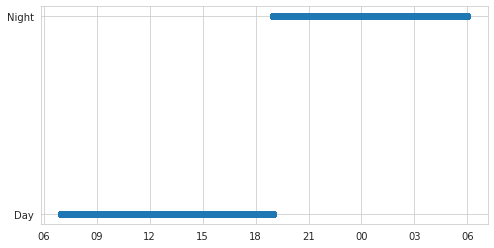

In [20]:
# Check change over time with plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot_date(x=df['Period'], y=df['Shift'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
fig.show()

###Observations:

* shift change over time is 19:00 hours and 06:00
* This is consistant across all trucks

##Moving and waiting analysis
Investigate the amount of time each truck spends moving and waiting. This is critical as if a truck is waiting it is not moving ore and hence NOT MAKING MONEY!

In [21]:
# calc a one hot encoded moving column 1 = moving, 0 = stationary
df['Moving'] = df['Speed'].apply(lambda x: 1 if x > 0 else 0)
df.head()

# apply for all individual dfs
df_list = [df_HT10, df_HT11, df_HT12, df_HT13]

for truck_dataframe in df_list:
  truck_dataframe['Moving'] = truck_dataframe['Speed'].apply(lambda x: 1 if x > 0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [22]:
# count total percentage moving per truck
time_in_locs_per_truck = pd.crosstab(index=df['Truck'], columns=df['Moving']).stack() / len(df[df['Truck']=='HT10'])
print(time_in_locs_per_truck)

Truck  Moving
HT10   0         0.678058
       1         0.321942
HT11   0         0.651733
       1         0.348267
HT12   0         0.655839
       1         0.344161
HT13   0         0.658012
       1         0.341988
dtype: float64


In [23]:
# define helper functions to plot percentages ontop of bars

def with_hue(plot, feature, Number_of_categories, hue_categories, calibration=1):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i] * calibration
        for j in range(hue_categories):
            percentage = f'{100 * a[(j*Number_of_categories + i)]/(total):.1f}%'
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.05
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + 0.05 
            ax.annotate(percentage, (x, y), size = 10)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/(total):.1f}%'
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + 0.05 
        ax.annotate(percentage, (x, y), size = 10)
    plt.show()

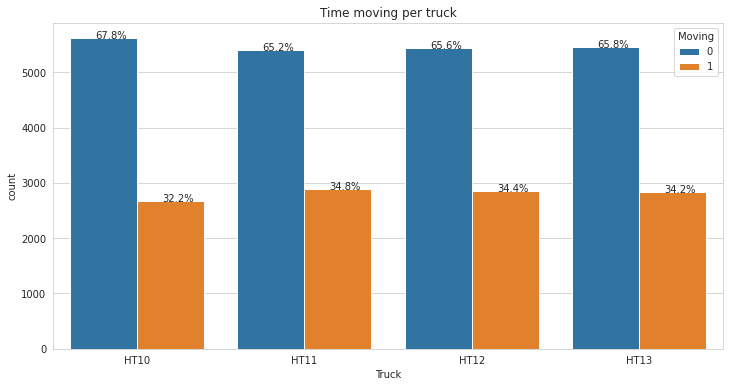

In [24]:
# plot operating time
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='Truck', hue='Moving', data=df)
plt.title('Time moving per truck')
with_hue(ax, df['Truck'], df['Truck'].nunique(), df['Moving'].nunique())
plt.show()

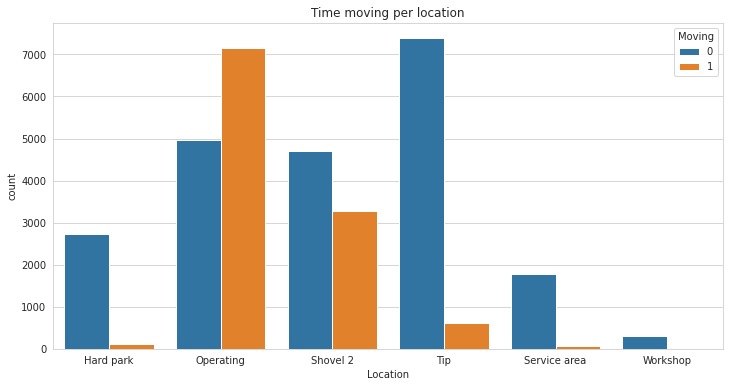

In [25]:
# Plot locations where not operating
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='Location', hue='Moving', data=df)
plt.title('Time moving per location')
plt.show()

In [26]:
time_in_locs = pd.crosstab(index=df['Location'], columns=df['Moving']).stack() / len(df)
print(time_in_locs)

Location      Moving
Hard park     0         0.082659
              1         0.003260
Operating     0         0.149891
              1         0.215735
Service area  0         0.053888
              1         0.001842
Shovel 2      0         0.141951
              1         0.098931
Tip           0         0.223011
              1         0.018657
Workshop      0         0.009510
              1         0.000664
dtype: float64


###Observations:

* Truck moving and waiting time is fairly consistant
* Trucks spend 2/3 time waiting
* HT10 is has slightly longer waiting time than the rest
* The largest difference in moving and waiting is at the tip where trucks wait significantly longer
* Large wait times at operating, shovel2 and tip.

If revenue is to be maximised these wait times must be reduced

##Time Investigation

Investigate the time each truck spends in each location

In [27]:
# determine total time 
total_time = df['Period'].max() - df['Period'].min()
print(f'Total time logged: {total_time}')

Total time logged: 0 days 23:00:00


In [28]:
# determine time in each location for each truck

time_in_locs = pd.crosstab(index=df['Truck'], columns=df['Location']).stack() / len(df[df['Truck']=='HT10'])
print(time_in_locs)

Truck  Location    
HT10   Hard park       0.036348
       Operating       0.288492
       Service area    0.093829
       Shovel 2        0.211327
       Tip             0.370004
       Workshop        0.000000
HT11   Hard park       0.107475
       Operating       0.388721
       Service area    0.025118
       Shovel 2        0.193696
       Tip             0.244777
       Workshop        0.040213
HT12   Hard park       0.109045
       Operating       0.389204
       Service area    0.054341
       Shovel 2        0.324357
       Tip             0.123053
       Workshop        0.000000
HT13   Hard park       0.090810
       Operating       0.396087
       Service area    0.049632
       Shovel 2        0.234150
       Tip             0.228837
       Workshop        0.000483
dtype: float64


In [29]:
# return sorted percentages per truck
for truck in trucks:
  print(f'Truck: {truck}')
  print(time_in_locs[truck].sort_values(ascending=False))
  print('')

Truck: HT10
Location
Tip             0.370004
Operating       0.288492
Shovel 2        0.211327
Service area    0.093829
Hard park       0.036348
Workshop        0.000000
dtype: float64

Truck: HT11
Location
Operating       0.388721
Tip             0.244777
Shovel 2        0.193696
Hard park       0.107475
Workshop        0.040213
Service area    0.025118
dtype: float64

Truck: HT12
Location
Operating       0.389204
Shovel 2        0.324357
Tip             0.123053
Hard park       0.109045
Service area    0.054341
Workshop        0.000000
dtype: float64

Truck: HT13
Location
Operating       0.396087
Shovel 2        0.234150
Tip             0.228837
Hard park       0.090810
Service area    0.049632
Workshop        0.000483
dtype: float64



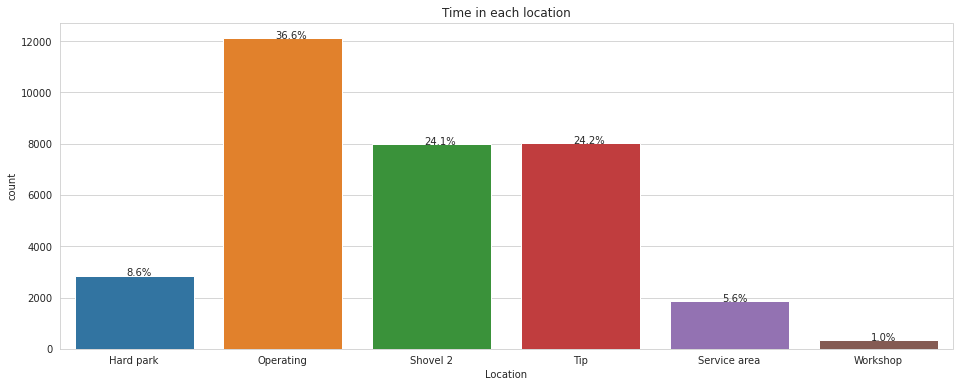

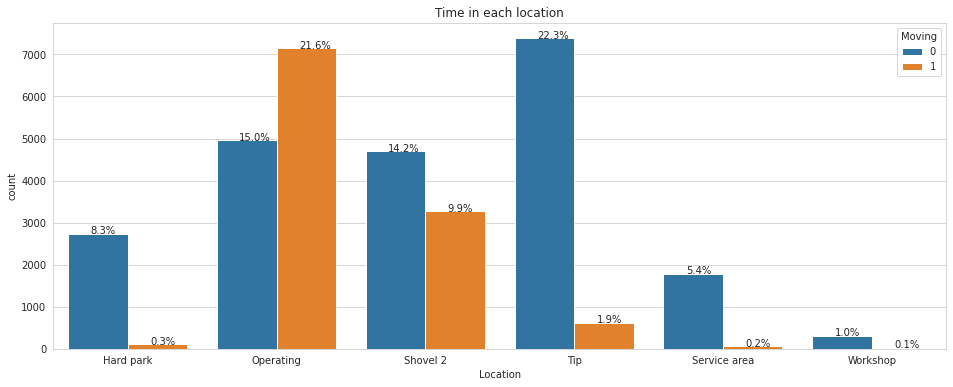

In [30]:
# Plot time in each location
fig, ax = plt.subplots(figsize=(16, 6))
sns.countplot(x='Location', data=df)
plt.title('Time in each location')
without_hue(ax, df['Location'])
plt.show()

# investigate with moving hue
fig, ax = plt.subplots(figsize=(16, 6))
sns.countplot(x='Location', data=df, hue='Moving')
plt.title('Time in each location')
without_hue(ax, df['Location'])
plt.show()

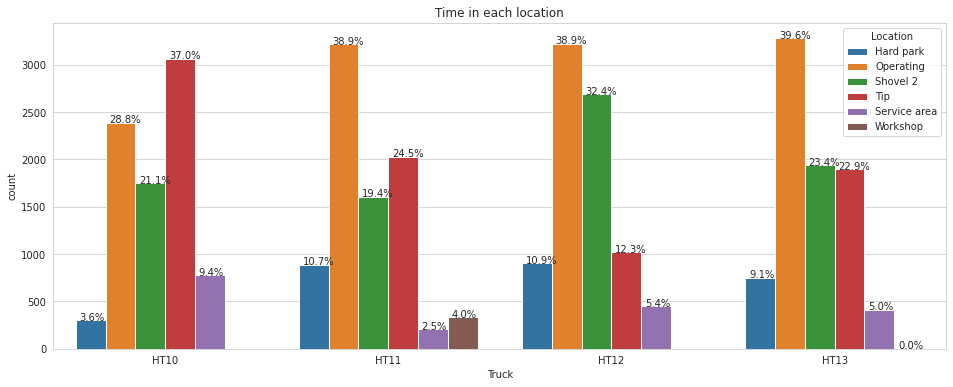

In [31]:
# Plot individual times per truck
fig, ax = plt.subplots(figsize=(16, 6))
sns.countplot(x='Truck', hue='Location', data=df)
plt.title('Time in each location')
with_hue(ax, df['Truck'], df['Truck'].nunique(), df['Location'].nunique())
plt.show()

###Observations

* Majority of time is spent in the correct locations (shovel, tip and operating)
* 8.6% in hard park, why?
* HT10 had longer waiting time than others but also longer tip time and lower operating time. Could this be because it was waiting in the tip for longer than others?

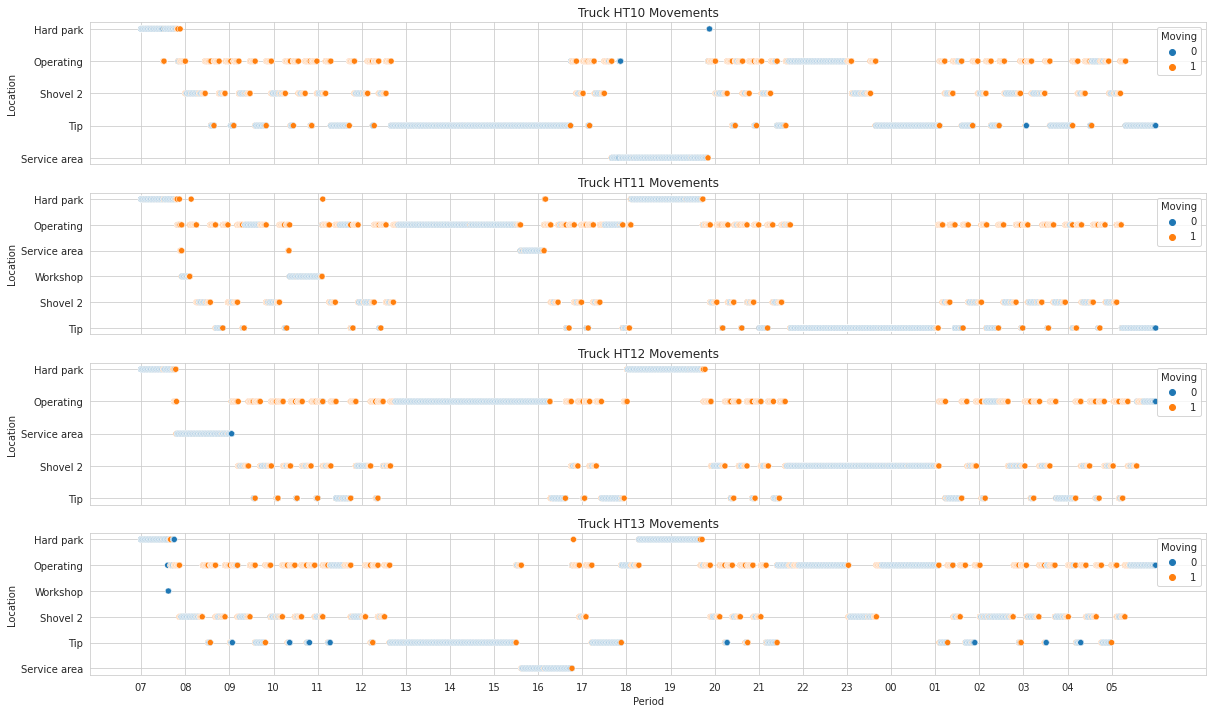

In [39]:
# plot date vs location

fig, ax = plt.subplots(sharex=True, figsize=(20,12), nrows=len(df_list), ncols=1)
for i in range(0, len(df_list)):
    
    sns.scatterplot(ax=ax[i], data=df_list[i], x='Period', y='Location', hue='Moving')
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax[i].set_title(f'Truck {df_list[i]["Truck"].iloc[0]} Movements')

plt.xticks(np.arange(min(df_list[i]['Period']), max(df_list[i]['Period']), timedelta(hours=1)))
plt.show()

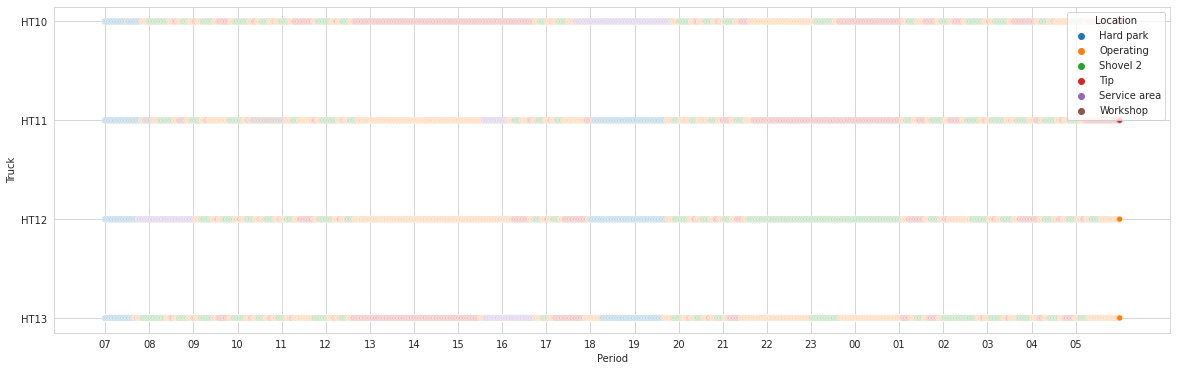

In [48]:
# Investigate the number of trucks in the same location
fig, ax = plt.subplots(figsize=(20,6))

sns.scatterplot(data=df, x='Period', y='Truck', hue='Location')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(np.arange(min(df['Period']), max(df['Period']), timedelta(hours=1)))
plt.show()

###Observation

*   Large break in activities from 12:30 till 15:30
*   HT10 and HT13 are in the tip together from approx 12:30 till 15:30. This corresponds to the longer wait time for HT10 that we noticed earlier.
*   As noted earlier shift change over is not staggered and occurs all at once




## Number of kms per shift

In [96]:
# determine cumulative sums of kms for each truck
def cumsum_analysis(dataframe, truck):

    dataframe['cumsum_kms'] = dataframe.loc[:, ('Kms')].cumsum() 
    dataframe['cumsum_day_kms'] = dataframe[dataframe['Shift']=='Day'].loc[:, ('Kms')].cumsum() 
    dataframe['cumsum_night_kms'] = dataframe[dataframe['Shift']=='Night'].loc[:, ('Kms')].cumsum() 
    print(f'Truck: {truck}')
    print('-'*10)
    print(f'Max km: {dataframe["cumsum_kms"].max():.2f} km')
    print(f'Max km in day shift by truck HT10: {dataframe["cumsum_day_kms"].max():.2f} km')
    print(f'Max km in night shift by truck HT10: {dataframe["cumsum_night_kms"].max():.2f} km\n')

    return dataframe

df_HT10 = cumsum_analysis(df_HT10, 'HT10')
df_HT11 = cumsum_analysis(df_HT11, 'HT11')
df_HT12 = cumsum_analysis(df_HT12, 'HT12')
df_HT13 = cumsum_analysis(df_HT13, 'HT13')

Truck: HT10
----------
Max km: 210.57 km
Max km in day shift by truck HT10: 105.42 km
Max km in night shift by truck HT10: 105.14 km

Truck: HT11
----------
Max km: 213.95 km
Max km in day shift by truck HT10: 99.37 km
Max km in night shift by truck HT10: 114.58 km

Truck: HT12
----------
Max km: 199.50 km
Max km in day shift by truck HT10: 96.06 km
Max km in night shift by truck HT10: 103.45 km

Truck: HT13
----------
Max km: 203.96 km
Max km in day shift by truck HT10: 99.16 km
Max km in night shift by truck HT10: 104.80 km



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

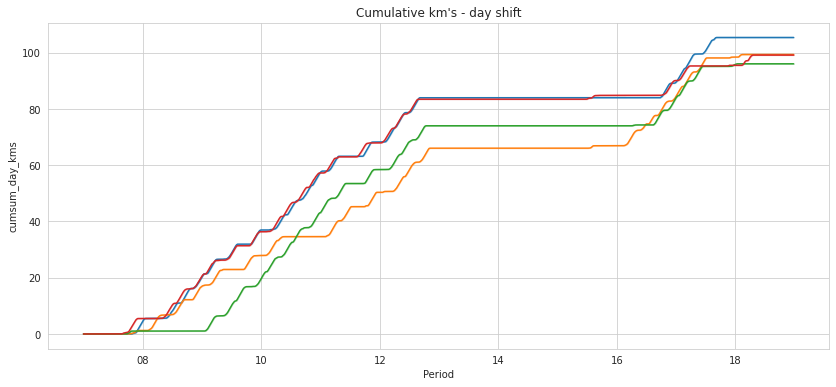

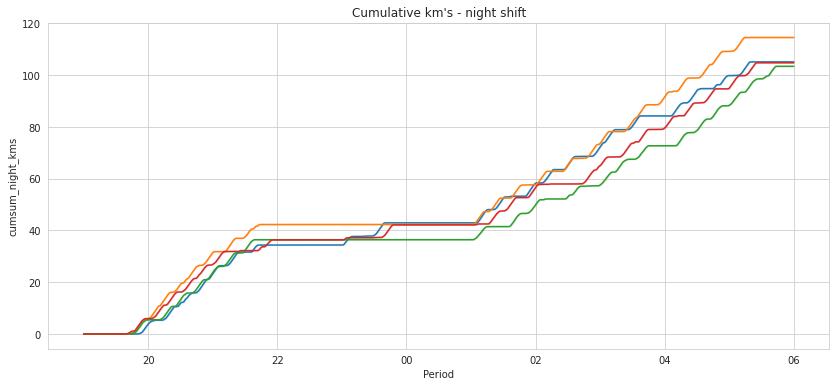

In [95]:
# plot cumulative kms per truck per shift

# day shift
fig, ax = plt.subplots(figsize=(14,6))

sns.lineplot(data=df_HT10, x=df_HT10['Period'], y=df_HT10['cumsum_day_kms'])
sns.lineplot(data=df_HT11, x=df_HT11['Period'], y=df_HT11['cumsum_day_kms'])
sns.lineplot(data=df_HT12, x=df_HT12['Period'], y=df_HT12['cumsum_day_kms'])
sns.lineplot(data=df_HT13, x=df_HT13['Period'], y=df_HT13['cumsum_day_kms'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.title.set_text("Cumulative km's - day shift") 
plt.show()

fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(data=df_HT10, x=df_HT10['Period'], y=df_HT10['cumsum_night_kms'])
sns.lineplot(data=df_HT11, x=df_HT11['Period'], y=df_HT11['cumsum_night_kms'])
sns.lineplot(data=df_HT12, x=df_HT12['Period'], y=df_HT12['cumsum_night_kms'])
sns.lineplot(data=df_HT13, x=df_HT13['Period'], y=df_HT13['cumsum_night_kms'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.title.set_text("Cumulative km's - night shift") 
plt.show()

###Observations

* Similar number of km's per truck with some variation
* Large breaksbetween 13:00 and 16:00 and 22:00 and 00:00
* Each truck cyles (inferred from Truck HT10 movements):
1. Truck 1 - Day: 10 / Night: 10
2. Truck 2 - Day: 8 / Night: 11
3. Truck 3 - Day: 9 / Night: 9
4. Truck 4 - Day: 9 / Night: 9
5. Average Day: 9 / Night: 9.75
* Day slightly less cycles than night however broadly similar

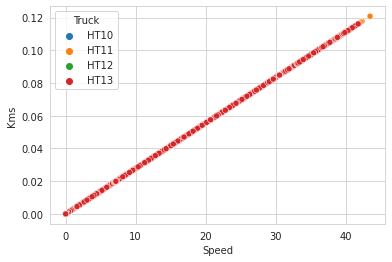

In [120]:
# review correlation between speed and kms

sns.scatterplot(data=df, x='Speed', y='Kms', hue='Truck')

###Observation

* Rather obviously increasing speed increases kms covered. Could this lead to more ore being cycled?
* Similar kms per shift however night shift covers more kms

## Geospatial plot

### Locations

Assess the locations and truck paths and plot a geospatial map

In [97]:
# return min and max lat and long
max_lat = df['Latitude'].max()
min_lat = df['Latitude'].min()

max_long = df['Longitude'].max()
min_long = df['Longitude'].min()

In [98]:
# Find locations
locations = df['Location'].unique()
print(f'Locations: {locations}')

Locations: ['Hard park' 'Operating' 'Shovel 2' 'Tip' 'Service area' 'Workshop']


In [99]:
# find bounds of each location for plotting
# hard park
hardpark_min_lat = df[df['Location']=='Hard park']['Latitude'].min()
hardpark_max_lat = df[df['Location']=='Hard park']['Latitude'].max()
hardpark_min_long = df[df['Location']=='Hard park']['Longitude'].min()
hardpark_max_long = df[df['Location']=='Hard park']['Longitude'].max()
hardpark_height = hardpark_max_long - hardpark_min_long
hardpark_width = hardpark_max_lat - hardpark_min_lat
hardpark_origin = (hardpark_min_lat, hardpark_min_long)
hardpark_rect = patches.Rectangle((hardpark_origin), hardpark_width, hardpark_height, color='b') 

# Shovel 2
shovel2_min_lat = df[df['Location']=='Shovel 2']['Latitude'].min()
shovel2_max_lat = df[df['Location']=='Shovel 2']['Latitude'].max()
shovel2_min_long = df[df['Location']=='Shovel 2']['Longitude'].min()
shovel2_max_long = df[df['Location']=='Shovel 2']['Longitude'].max()
shovel2_height = shovel2_max_long - shovel2_min_long
shovel2_width = shovel2_max_lat - shovel2_min_lat
shovel2_origin = (shovel2_min_lat, shovel2_min_long)
shovel2_rect = patches.Rectangle((shovel2_origin), shovel2_width, shovel2_height, color='y')

# Tip
tip_min_lat = df[df['Location']=='Tip']['Latitude'].min()
tip_max_lat = df[df['Location']=='Tip']['Latitude'].max()
tip_min_long = df[df['Location']=='Tip']['Longitude'].min()
tip_max_long = df[df['Location']=='Tip']['Longitude'].max()
tip_height = tip_max_long - tip_min_long
tip_width = tip_max_lat - tip_min_lat
tip_origin = (tip_min_lat, tip_min_long)
tip_rect = patches.Rectangle((tip_origin), tip_width, tip_height, color='g')

# Service area
service_min_lat = df[df['Location']=='Service']['Latitude'].min()
service_max_lat = df[df['Location']=='Service']['Latitude'].max()
service_min_long = df[df['Location']=='Service']['Longitude'].min()
service_max_long = df[df['Location']=='Service']['Longitude'].max()
service_height = service_max_long - service_min_long
service_width = service_max_lat - service_min_lat
service_origin = (service_min_lat, service_min_long)
service_rect = patches.Rectangle((service_origin), service_width, service_height, color='m')

# Workshop
workshop_min_lat = df[df['Location']=='Workshop']['Latitude'].min()
workshop_max_lat = df[df['Location']=='Workshop']['Latitude'].max()
workshop_min_long = df[df['Location']=='Workshop']['Longitude'].min()
workshop_max_long = df[df['Location']=='Workshop']['Longitude'].max()
workshop_height = workshop_max_long - workshop_min_long
workshop_width = workshop_max_lat - workshop_min_lat
workshop_origin = (workshop_min_lat, workshop_min_long)
workshop_rect = patches.Rectangle((workshop_origin), workshop_width, workshop_height, color='palegreen')

# location rectangle list
location_list = [hardpark_rect, shovel2_rect, tip_rect, service_rect, workshop_rect]
location_names = ['hardpark', 'shovel2', 'tip', 'service', 'workshop']

<Figure size 432x288 with 0 Axes>

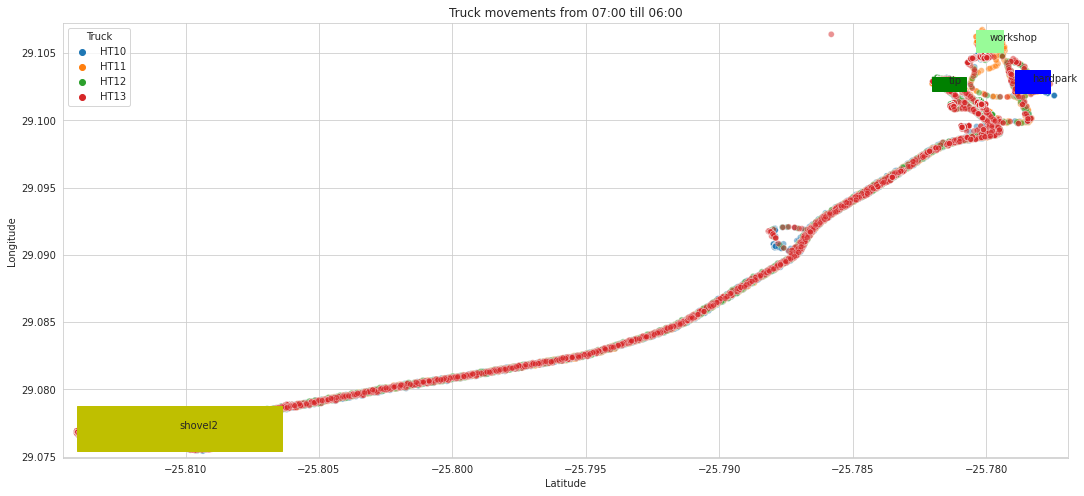

In [115]:
    fig = plt.figure()

    lat_long_offset = 0.0005
    # create geospatial plot
    fig, ax = plt.subplots(figsize=(18, 8))
    plt.title(f'Truck movements from {df[df["Truck"]==truck]["Period"].min():%H}:00 till {df[df["Truck"]==truck]["Period"].max():%H}:00')

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')

    # set axis limits
    ax.set_xlim([(df['Latitude'].min() - lat_long_offset), (df['Latitude'].max() + lat_long_offset)])
    ax.set_ylim([(df['Longitude'].min() - lat_long_offset), (df['Longitude'].max() + lat_long_offset)])

    # add locations to plot
    for j in range(0, len(location_list)):
        c = copy(location_list[j])
        ax.add_patch(c)
        x_centre_of_patch = location_list[j].get_x() + location_list[j].get_width() / 2
        y_centre_of_patch = location_list[j].get_y() + location_list[j].get_height() / 2
        plt.annotate(f'{location_names[j]}', (x_centre_of_patch, y_centre_of_patch))

    sns.scatterplot(data=df, x='Latitude', y='Longitude', hue='Truck', alpha=0.5)

# GEOSPATIAL DATA MAIN OBSERVATIONS AND RECOMENDATIONS

Since this is a single day it is difficult to say whether this is a typical day. However, the observations and recomendations below are derived from this single days data assuming it is consistant across weeks/months.

1.   There is alot of truck time spent not moving and hence not cycling ore. The trucks spend approximately 2/3 of their time waiting. Waiting time should be reduced so that more ore can be cycled.
2.  Shift change over time is at 19:00 hours and 06:00 hours. This is the same across all trucks leading to significant down time where no ore is cycled. Shifts should be staggered so that there is never any significant downtime and there are always trucks running.
3. Trucks should be staggered in a relay fashion so that there are no clashes in the tip. HT13 often clashes with other trucks when in the tip leading to increased wait times.
4. Approx. half way through each shift there is a long break. It is difficult to determine what causes this without asking further quesitons. This however leads to a drop in productivity as all trucks are stationary. If this is a break it should be staggered to prevent serious downtime. This could alleviate some issues with trucks waiting at the tip.



#2. Profit Data
Investigate data from profit excel file

1.  Process the financial information and identify the reasons for the difference between budget and actual. 

2.  Provide suggestions on improving the budgeting process and the benefits of improving operations (e.g. create three scenarios indicating how your suggestions will improve the financial position of the mine)

## Dataframe creation

In [121]:
'''
Create dataframe of the finanical data. This could be automatically input by 
changing the xlsx file to be more python freindly. However, to keep it as 
reproducable as possible the xlsx file will be left the same and data manually
added. This is not a good idea with lots of data!
'''

budget_dict = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
    'coal_tonnes': [90000.00, 100000.00, 100000.00, 100000.00, 100000.00, 100000.00, 100000.00, 100000.00, 100000.00, 100000.00, 100000.00, 80000.00],
    'revenue_USD': [5310000.00, 5900000.00, 5900000.00, 5900000.00, 5900000.00, 2600000.00, 5900000.00, 5900000.00, 5900000.00, 5900000.00, 5900000.00, 4720000.00],
    'exchange_rate_ZAR/USD': [10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75],
    'total_cost_ZAR': [35333333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 37833333.33, 32833333.33],
    'number_of_trucks': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    'cost_per_truck_ZAR': [166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67, 166666.67],
    'other_mining_costs_ZAR': [2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00, 2500000.00],
    'salaries_ZAR': [6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00, 6500000.00],
    'technical_services_ZAR': [3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00, 3000000.00]
}

actual_dict = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
    'coal_tonnes': [75231.00, 95113.00, 103281.00, 98751.00, 91289.00, 93265.00, 90448.00, 89568.00, 43962.00, 88560.00, 82150.00, 64189.00],
    'revenue_USD': [4137705.00, 4945876.00, 5783736.00, 5036301.00, 5386051.00, 5782430.00, 5426880.00, 5687568.00, 5503368.00, 5402160.00, 4929000.00, 3819245.50],
    'exchange_rate_ZAR/USD': [10.63, 11.00, 10.67, 10.46, 10.40, 10.58, 10.71, 10.59, 11.08, 11.06, 10.96, 11.62],
    'total_cost_ZAR': [37473706.33, 40437148.33, 41177335.33, 40673581.33, 39553317.33, 40525498.33, 40242501.33, 40097989.33, 39972085.33, 40271653.33, 39924683.33, 35504222.33],
    'number_of_trucks': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    'cost_per_truck_ZAR': [266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67, 266666.67],
    'other_mining_costs_ZAR': [5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00, 5200000.00],
    'salaries_ZAR': [7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00, 7000000.00],
    'technical_services_ZAR': [2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00, 2650000.00]
}

# create dfs
budget_df = pd.DataFrame(budget_dict)
actual_df = pd.DataFrame(actual_dict)

In [122]:
# check dataframes
actual_df.info()
actual_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   12 non-null     object 
 1   coal_tonnes             12 non-null     float64
 2   revenue_USD             12 non-null     float64
 3   exchange_rate_ZAR/USD   12 non-null     float64
 4   total_cost_ZAR          12 non-null     float64
 5   number_of_trucks        12 non-null     int64  
 6   cost_per_truck_ZAR      12 non-null     float64
 7   other_mining_costs_ZAR  12 non-null     float64
 8   salaries_ZAR            12 non-null     float64
 9   technical_services_ZAR  12 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.1+ KB


,month,coal_tonnes,revenue_USD,exchange_rate_ZAR/USD,total_cost_ZAR,number_of_trucks,cost_per_truck_ZAR,other_mining_costs_ZAR,salaries_ZAR,technical_services_ZAR
0,Jan,75231.0,4137705.0,10.63,37473706.33,5,266666.67,5200000.0,7000000.0,2650000.0
1,Feb,95113.0,4945876.0,11.00,40437148.33,5,266666.67,5200000.0,7000000.0,2650000.0
2,Mar,103281.0,5783736.0,10.67,41177335.33,5,266666.67,5200000.0,7000000.0,2650000.0
3,Apr,98751.0,5036301.0,10.46,40673581.33,5,266666.67,5200000.0,7000000.0,2650000.0
4,May,91289.0,5386051.0,10.40,39553317.33,5,266666.67,5200000.0,7000000.0,2650000.0


In [123]:
budget_df.info()
budget_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   12 non-null     object 
 1   coal_tonnes             12 non-null     float64
 2   revenue_USD             12 non-null     float64
 3   exchange_rate_ZAR/USD   12 non-null     float64
 4   total_cost_ZAR          12 non-null     float64
 5   number_of_trucks        12 non-null     int64  
 6   cost_per_truck_ZAR      12 non-null     float64
 7   other_mining_costs_ZAR  12 non-null     float64
 8   salaries_ZAR            12 non-null     float64
 9   technical_services_ZAR  12 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.1+ KB


,month,coal_tonnes,revenue_USD,exchange_rate_ZAR/USD,total_cost_ZAR,number_of_trucks,cost_per_truck_ZAR,other_mining_costs_ZAR,salaries_ZAR,technical_services_ZAR
0,Jan,90000.0,5310000.0,10.75,35333333.33,5,166666.67,2500000.0,6500000.0,3000000.0
1,Feb,100000.0,5900000.0,10.75,37833333.33,5,166666.67,2500000.0,6500000.0,3000000.0
2,Mar,100000.0,5900000.0,10.75,37833333.33,5,166666.67,2500000.0,6500000.0,3000000.0
3,Apr,100000.0,5900000.0,10.75,37833333.33,5,166666.67,2500000.0,6500000.0,3000000.0
4,May,100000.0,5900000.0,10.75,37833333.33,5,166666.67,2500000.0,6500000.0,3000000.0


##High level data analysis

In [129]:
actual_df.describe(include='all')

,month,coal_tonnes,revenue_USD,exchange_rate_ZAR/USD,total_cost_ZAR,number_of_trucks,cost_per_truck_ZAR,other_mining_costs_ZAR,salaries_ZAR,technical_services_ZAR
count,12,12.000000,1.200000e+01,12.000000,1.200000e+01,12.0,12.00,12.0,12.0,12.0
unique,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Mar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,84650.583333,5.153360e+06,10.813333,3.965448e+07,5.0,266666.67,5200000.0,7000000.0,2650000.0
std,NaN,16558.289127,6.259794e+05,0.344287,1.590220e+06,0.0,0.00,0.0,0.0,0.0
min,NaN,43962.000000,3.819246e+06,10.400000,3.550422e+07,5.0,266666.67,5200000.0,7000000.0,2650000.0
25%,NaN,80420.250000,4.941657e+06,10.587500,3.983184e+07,5.0,266666.67,5200000.0,7000000.0,2650000.0
50%,NaN,90008.000000,5.394106e+06,10.690000,4.017025e+07,5.0,266666.67,5200000.0,7000000.0,2650000.0
75%,NaN,93727.000000,5.549418e+06,11.015000,4.045924e+07,5.0,266666.67,5200000.0,7000000.0,2650000.0


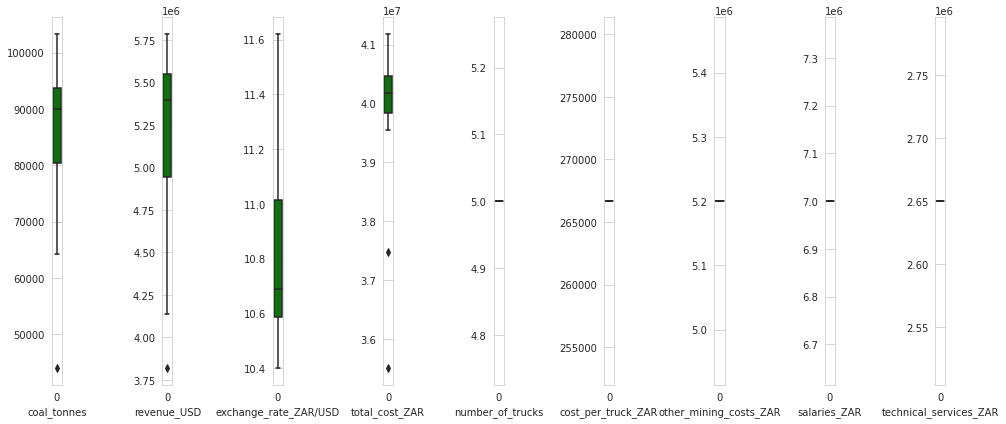

In [125]:
data_numeric_box_plot(actual_df.drop('month', axis=1), 9)

### Correlations

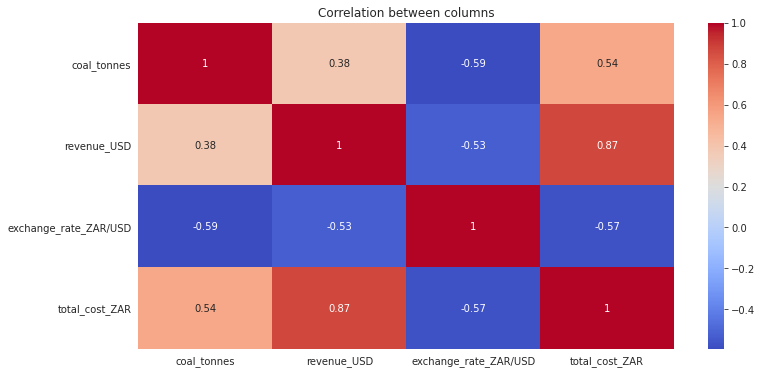

In [130]:
# plot heat map of correlations
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(actual_df.drop(['number_of_trucks', 'cost_per_truck_ZAR', 'other_mining_costs_ZAR', 'salaries_ZAR', 'technical_services_ZAR'], axis=1).corr(), cmap='coolwarm', annot=True)
plt.title('Correlation between columns')
plt.show()

Interestingly the highest correlation is between revenue (USD) and total cost_ZAR (0.87) and the relatively small correlation between tonnes of coal and revenue (0.38)

Plot these correlations to view results

<Figure size 864x432 with 0 Axes>

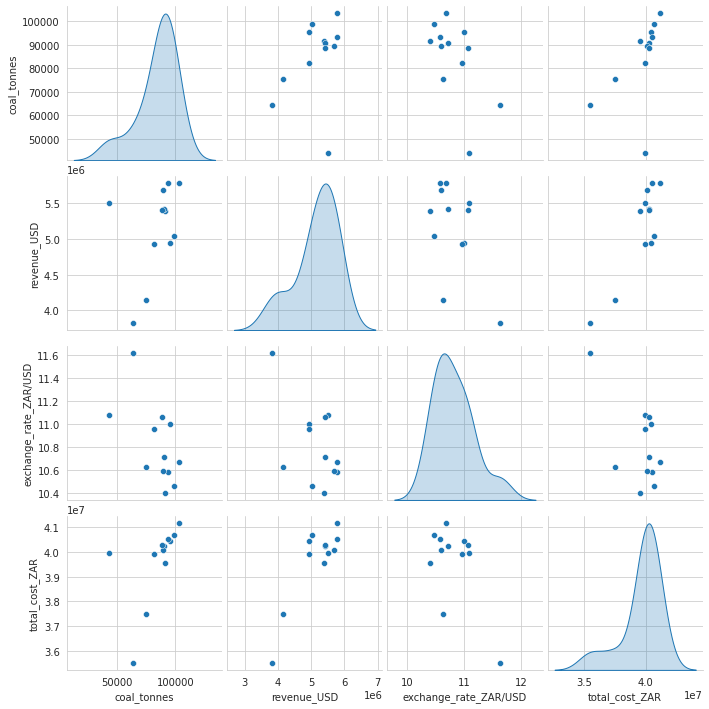

In [139]:
plt.figure(figsize=(12, 6))
sns.pairplot(data=actual_df.drop(['number_of_trucks', 'cost_per_truck_ZAR', 'other_mining_costs_ZAR', 'salaries_ZAR', 'technical_services_ZAR'], axis=1), kind='scatter', diag_kind='kde')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


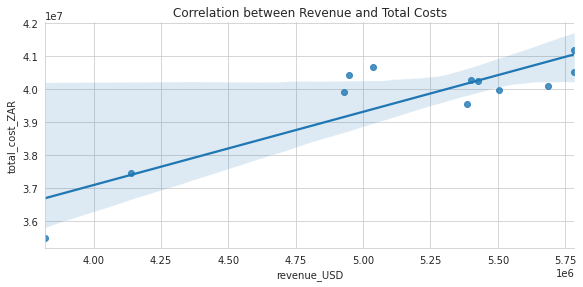

In [142]:
# plot correlation between revenue and total costs
sns.lmplot(x='revenue_USD', y='total_cost_ZAR', data=actual_df, size=4, aspect=2)
plt.title('Correlation between Revenue and Total Costs')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


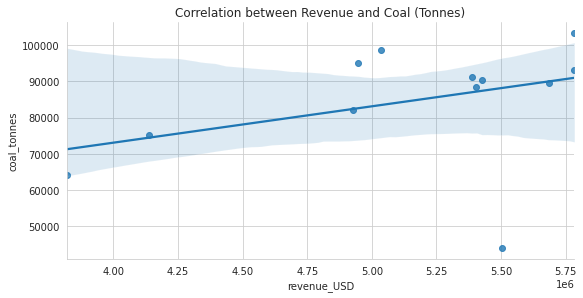

In [143]:
# plot correlation between revenue and coal
sns.lmplot(x='revenue_USD', y='coal_tonnes', data=actual_df, size=4, aspect=2)
plt.title('Correlation between Revenue and Coal (Tonnes)')
plt.show()

###Observation

* Increase the amount of coal results in increased revenue

## Total v Budget

Review the dataframes budget v actual

In [146]:
budget_df.sum()

month                     JanFebMarAprMayJuneJulyAugSeptOctNovDec
coal_tonnes                                              1.17e+06
revenue_USD                                             6.573e+07
exchange_rate_ZAR/USD                                         129
total_cost_ZAR                                          4.465e+08
number_of_trucks                                               60
cost_per_truck_ZAR                                          2e+06
other_mining_costs_ZAR                                      3e+07
salaries_ZAR                                              7.8e+07
technical_services_ZAR                                    3.6e+07
dtype: object

In [147]:
actual_df.sum()

month                     JanFebMarAprMayJuneJulyAugSeptOctNovDec
coal_tonnes                                           1.01581e+06
revenue_USD                                           6.18403e+07
exchange_rate_ZAR/USD                                      129.76
total_cost_ZAR                                        4.75854e+08
number_of_trucks                                               60
cost_per_truck_ZAR                                        3.2e+06
other_mining_costs_ZAR                                   6.24e+07
salaries_ZAR                                              8.4e+07
technical_services_ZAR                                   3.18e+07
dtype: object

In [158]:
variance = actual_df.drop('month', axis=1) - budget_df.drop('month', axis=1)
variance.head(12)


,coal_tonnes,revenue_USD,exchange_rate_ZAR/USD,total_cost_ZAR,number_of_trucks,cost_per_truck_ZAR,other_mining_costs_ZAR,salaries_ZAR,technical_services_ZAR
0,-14769.0,-1172295.0,-0.12,2140373.0,0,100000.0,2700000.0,500000.0,-350000.0
1,-4887.0,-954124.0,0.25,2603815.0,0,100000.0,2700000.0,500000.0,-350000.0
2,3281.0,-116264.0,-0.08,3344002.0,0,100000.0,2700000.0,500000.0,-350000.0
3,-1249.0,-863699.0,-0.29,2840248.0,0,100000.0,2700000.0,500000.0,-350000.0
4,-8711.0,-513949.0,-0.35,1719984.0,0,100000.0,2700000.0,500000.0,-350000.0
5,-6735.0,3182430.0,-0.17,2692165.0,0,100000.0,2700000.0,500000.0,-350000.0
6,-9552.0,-473120.0,-0.04,2409168.0,0,100000.0,2700000.0,500000.0,-350000.0
7,-10432.0,-212432.0,-0.16,2264656.0,0,100000.0,2700000.0,500000.0,-350000.0
8,-56038.0,-396632.0,0.33,2138752.0,0,100000.0,2700000.0,500000.0,-350000.0
9,-11440.0,-497840.0,0.31,2438320.0,0,100000.0,2700000.0,500000.0,-350000.0


In [201]:
# return the sum of the variance
print(f'Variance from budget: {variance.sum()}')

print('')
# calculate largest percentage difference
perc_variance = (1 - (budget_df.drop('month', axis=1).sum() - variance.sum()) / actual_df.drop('month', axis=1).sum())* 100
print(f'\nPercentage variance from budget: \n{perc_variance}')

Variance from budget: coal_tonnes                -154193.00
revenue_USD               -3889679.50
exchange_rate_ZAR/USD            0.76
total_cost_ZAR            29353722.00
number_of_trucks                 0.00
cost_per_truck_ZAR         1200000.00
other_mining_costs_ZAR    32400000.00
salaries_ZAR               6000000.00
technical_services_ZAR    -4200000.00
dtype: float64


Percentage variance from budget: 
coal_tonnes               -30.358720
revenue_USD               -12.579752
exchange_rate_ZAR/USD       1.171393
total_cost_ZAR             12.337288
number_of_trucks            0.000000
cost_per_truck_ZAR         74.999999
other_mining_costs_ZAR    103.846154
salaries_ZAR               14.285714
technical_services_ZAR    -26.415094
dtype: float64


In [160]:
# describe the variance 
variance.describe()

,coal_tonnes,revenue_USD,exchange_rate_ZAR/USD,total_cost_ZAR,number_of_trucks,cost_per_truck_ZAR,other_mining_costs_ZAR,salaries_ZAR,technical_services_ZAR
count,12.000000,1.200000e+01,12.000000,1.200000e+01,12.0,1.200000e+01,12.0,12.0,12.0
mean,-12849.416667,-3.241400e+05,0.063333,2.446144e+06,0.0,1.000000e+05,2700000.0,500000.0,-350000.0
std,14875.517797,1.152217e+06,0.344287,4.235030e+05,0.0,1.519898e-11,0.0,0.0,0.0
min,-56038.000000,-1.172295e+06,-0.350000,1.719984e+06,0.0,1.000000e+05,2700000.0,500000.0,-350000.0
25%,-15029.500000,-9.140969e+05,-0.162500,2.139968e+06,0.0,1.000000e+05,2700000.0,500000.0,-350000.0
50%,-9992.000000,-5.058945e+05,-0.060000,2.423744e+06,0.0,1.000000e+05,2700000.0,500000.0,-350000.0
75%,-6273.000000,-3.505820e+05,0.265000,2.676208e+06,0.0,1.000000e+05,2700000.0,500000.0,-350000.0
max,3281.000000,3.182430e+06,0.870000,3.344002e+06,0.0,1.000000e+05,2700000.0,500000.0,-350000.0


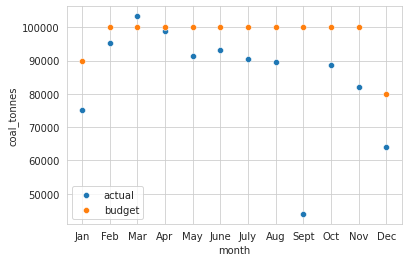

In [173]:
name_list = ['actual', 'budget']
dframe_list = [actual_df, budget_df]

col_names

for i in range(0, len(dframe_list)):
  sns.scatterplot(data=dframe_list[i], x='month', y='coal_tonnes', label=name_list[i])
  plt.legend()

###Observations
Reason for difference in budget and actual:

* -154,143 tonnes of coal less than budgeted for. Approx 30.34% less!
* -3,889,679.5 ZAR less revenue than budget(12.58%)
* Actual exchange rate was 0.063% greater than budget on average
* Total costs were 12.34% greater than budget.
* Cost per truck was greater than budget by 100,000 per month on average
* Other mining costs were greater than budget by 2,700,000 ZAR per month on average 
* Salaries were greater than budget by 500,000 ZAR on average
* Technical service costs wer reduced by 350,000 ZAR from budget to actual or 26.4%

The impact of exchange rate doesn't have as much impact as expected. It is fairly consistant.

## Provide suggestions on improving the budgeting process

The operation has not performed well financially to what was planned. There are large differences between the budget values and actual values. 

The budget process could be improved by reviewing previous years budgets and looking for trends in the data which can be used to inform the future years budget


NOTE: I RAN OUT OF TIME TO COMPLETE ANALYSIS FOR STEPS 1 AND 3

1. Increase ore throughput by improving efficiency of process

By far the greatest variance was in the tonnes of coal produced. Efficiencies in the ore production process (some of which are identified in section 1) should be improved and streamlined. This would result in a more consistant ore output resulting in improvements in budget performance and ease of forecasting.

2. Reduce costs

Option 2 is to reduce the costs spend to around budget levels as this was the second highest variance

NOTE: The below is a very basic high level analysis to show the potential impact of cutting costs

Some costs are easier to cut than others

In [185]:
# determine ZAR this year if costs were kept at budget
truck_cost = variance.sum()['cost_per_truck_ZAR']
other_mining_costs = variance.sum()['other_mining_costs_ZAR']
sals = variance.sum()['salaries_ZAR']
exch_rate = (variance.sum()['exchange_rate_ZAR/USD'] + budget_df['exchange_rate_ZAR/USD'][0])/100

# determine the yearly extra revenue from cutting costs
yearly_savings_cost_cutting_ZAR = truck_cost + other_mining_costs + sals
yearly_savings_cost_cutting_USD = yearly_savings_cost_cutting_ZAR * exch_rate
print(f'Additional yearly savings by cutting costs to budget level: {yearly_savings_cost_cutting_USD:.2f} USD')

# yearly revenue
yearly_actual_revenue = actual_df['revenue_USD'].sum()
inc_acutal_revenue_cost_cutting = yearly_actual_revenue + yearly_savings_cost_cutting_USD

# difference between budget and actual
cost_cutting_revenue = budget_df['revenue_USD'].sum() - inc_acutal_revenue_cost_cutting
print(cost_cutting_revenue)
actual_revenue = budget_df['revenue_USD'].sum()


Additional yearly savings by cutting costs to budget level: 4557960.00 USD
-668280.5


3. Increase technical services spend to reduce machinery costs 

This requires more data (geospatial) over a few months to determine trends in service and maintenance requirements of vehicle fleet.

The large drop in coal production in September, Dec and January could be due to failure of machinery. This would also coincide with the increase machinery costs (more maintenance, breakdown repair, etc).

Increase technical services spend to improve reliability of machinery may result in more ore production and less machinery spend.